## Import packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import random
import csv

from sklearn.utils import shuffle
from matplotlib import image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
random.seed(432)

## Define variables that will apply to all models:

In [2]:
# input and output folder
input_folder = "/kaggle/input/"
output_folder = "/kaggle/working/"

n_epochs = 3
batch_size = 128 # How big of a set of data to use for every training epoch

### Create a file to save test results

In [3]:
# Open the excel file where I'll save all the test results (metrics)

with open("./results.csv", "w") as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow(["model_name",
                         "removed_layer", 
                         "test_loss",
                         "test_accuracy",
                         "wa_precision", # wa = weighted average
                         "wa_recall",
                         "wa_f1_score",
                         "wrong_preds",
                         "total_preds",
                         "batch_size",
                         "num_train", # number of images in the training set
                         "num_val", # number of images in the validation set
                         "num_test", # number of images in the test set
                         "num_epochs_set", # cap set for num epochs
                         "num_epochs_run" # epoch where it stopped automatically
                        ])
    
# ADD A WAY TO PROPERLY DESCRIBE THE MODEL ARCHITECTURE: MAYBE GIVE A NAME TO EACH LAYER
# OF THE VGG, AND THEN LIST THE LAYER(S) REMOVED IN EACH SPECIFIC ITERATION.

# TODO

1. ADD A WAY TO PROPERLY DESCRIBE THE MODEL ARCHITECTURE IN THE EXCEL FILE
2. IN THE IMAGES (TRAINING ACCURACY, TRAINING LOSS, CONFUSION MATRIX), ADD THE NAME OF THE MODEL IN THE IMAGE TITLE.

### Define functions

In [4]:
# https://stackoverflow.com/questions/39280813/visualization-of-convolutional-layer-in-keras-model
# Merdan Memtimin https://stackoverflow.com/users/6565409/merdan-memtimin
def plot_conv_weights(model, layer_name):
    W = model.get_layer(name=layer_name).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [5]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df


In [6]:
def precision(confusion_matrix):
    """Given a confusion matrix, calculates and returns precision for all classes"""
    precision_list = []
    for i in range(confusion_matrix.shape[1]):
        current_col = confusion_matrix[:,[i]]
        current_el = confusion_matrix[i,[i]]
        current_precision = (float(current_el/sum(current_col)[0]))
        current_precision = round(current_precision, 4)
        precision_list.append(current_precision)
    return precision_list

def recall(confusion_matrix):
    """Given a confusion matrix, calculates and returns recall for all classes"""
    recall_list = []
    for i in range(confusion_matrix.shape[0]):
        current_row = confusion_matrix[i,:]
        current_el = confusion_matrix[i,i]
        current_recall = round(current_el/sum(current_row), 4)
        recall_list.append(current_recall)
    return(recall_list)

def f1_score(precision, recall):
    """Given a list of precision and recall values for a certain matrix,
    returns f-1 values for each class"""
    f1_scores = []
    if len(precision) == len(recall):
        for i in range(len(precision)):
            current_f1 = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
            f1_scores.append(round(current_f1, 4))
    else:
        print("Error. Precision and Recall lists should be of equal lengths.")
    return f1_scores

## Load data

In [7]:
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

## Preprocessing

In [8]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

In [9]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, # for replicability. Anyways they are already shuffled.
)

print("\nBuilding validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\nBuilding test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Building training set.
Found 18900 validated image filenames belonging to 10 classes.

Building validation set.
Found 5400 validated image filenames belonging to 10 classes.

Building test set
Found 2700 validated image filenames belonging to 10 classes.


In [10]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

class_count = len(class_name_list)

# Ablation
For this ablations study, I am going to focus on VGG16, as it is a simpler model than the models proposed by the EuroSAT original paper, but still a deep model with which I achived very close to State-of-the-Art (SoA) performance.

## VGG16, the Original

In [11]:
model_name = "base_vgg16"
model = Sequential()

# start of VGG16
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# end of VGG16

# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


In [12]:
# model.summary()

In [13]:
model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 5 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [14]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=n_epochs,
    verbose=1,
)

# Get the number of epochs the model ran for (to track early stopping):
n_ran_epochs = len(history.history['loss'])

Epoch 1/3
148/148 [==============================] - 84s 474ms/step - loss: 1.9252 - accuracy: 0.2240 - val_loss: 1.6442 - val_accuracy: 0.2991
Epoch 2/3
148/148 [==============================] - 29s 192ms/step - loss: 1.3833 - accuracy: 0.4127 - val_loss: 1.3029 - val_accuracy: 0.4526
Epoch 3/3
148/148 [==============================] - 29s 195ms/step - loss: 1.0424 - accuracy: 0.6016 - val_loss: 0.7685 - val_accuracy: 0.7226


In [16]:
#plot_conv_weights(model, "conv2d_35")

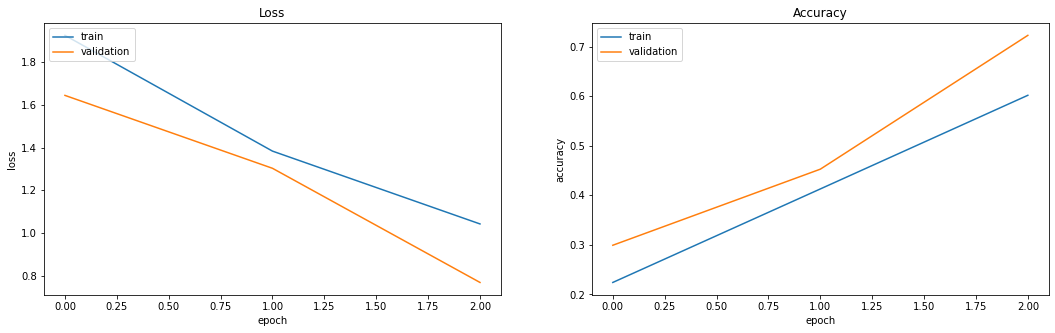

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.show()
plt.savefig(output_folder + model_name + "_training_curves.png")

## Predict and Evaluate Model

In [18]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 8s 369ms/step - loss: 0.7424 - accuracy: 0.7330


In [19]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
# Computation is done in batches.
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 3s 1ms/step


In [20]:
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)

wa_prec = report["weighted avg"]["precision"]
wa_rec = report["weighted avg"]["recall"]
wa_f1 = report["weighted avg"]["f1-score"]

              precision    recall  f1-score   support

           0     0.8547    0.8233    0.8387       300
           1     0.7354    0.9633    0.8341       300
           2     0.5300    0.6767    0.5944       300
           3     0.5531    0.3960    0.4615       250
           4     0.8258    0.9480    0.8827       250
           5     0.5594    0.5650    0.5622       200
           6     0.5787    0.5440    0.5608       250
           7     0.8846    0.9200    0.9020       300
           8     0.7101    0.3920    0.5052       250
           9     0.9965    0.9367    0.9656       300

    accuracy                         0.7330      2700
   macro avg     0.7228    0.7165    0.7107      2700
weighted avg     0.7330    0.7330    0.7242      2700



In [21]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=cf_matrix, 
    index=class_name_list, 
    columns=class_name_list
)

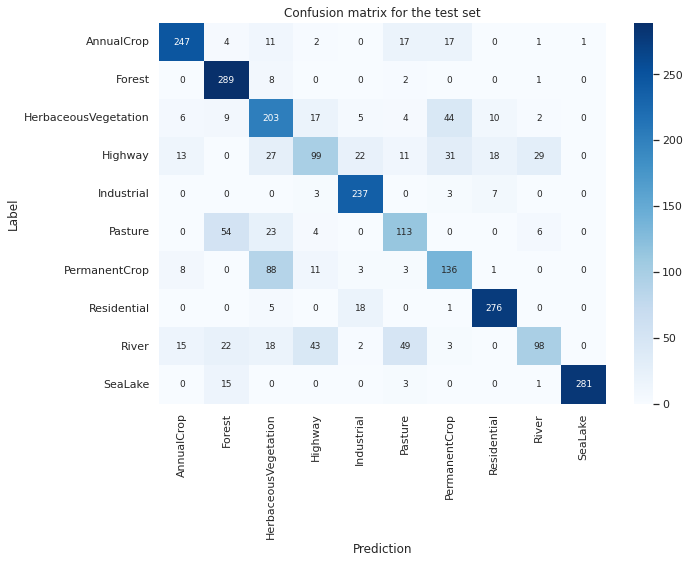

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()
plt.savefig(output_folder + model_name + "_confusion.png")

In [23]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

wrong_preds = len(mistakes_df)
tot_preds = len(results_df)

print(f"{wrong_preds} wrong predictions out of {tot_preds}")

721 wrong predictions out of 2700


In [24]:
# Add results to the results csv file:

with open("./results.csv", 'a+', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow([model,
                         "removed_layer", 
                         loss,
                         accuracy,
                         wa_prec,
                         wa_rec,
                         wa_f1,
                         wrong_preds,
                         tot_preds,
                         batch_size,
                         len(training_df), # number of images in the training set
                         len(validation_df), # number of images in the validation set
                         len(test_df), # number of images in the test set
                         n_epochs, # cap set for num epochs
                         n_ran_epochs # epoch where it stopped automatically
                        ])
    

# START ABLATION STUDY

In [25]:
def run_model(model, model_name):
    model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"
    # Save the weigths of the best model
    checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
    # Reduce learning rate when val_loss stops improving for 5 epochs.
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    # Stop training if a val_loss has stopped improving for 5 epochs.
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
    callback_list = [checkpoint, early_stopping, reduce_lr]
    
    model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

    history = model.fit(
        training_set,
        validation_data=validation_set,
        callbacks=callback_list,
        epochs=n_epochs,
        verbose=1,
    )

    return history

In [26]:
def get_eval_metrics(history, model, test_set):
    n_ran_epochs = len(history.history['loss'])
    loss, accuracy = model.evaluate(test_set, verbose=1)
    test_set.reset()
    predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
    predicted_class_ids = np.argmax(predicted_probabilities, axis=1)
    report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)
    wa_prec = report["weighted avg"]["precision"]
    wa_rec = report["weighted avg"]["recall"]
    wa_f1 = report["weighted avg"]["f1-score"]
    cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
    confusion_matrix_df = pd.DataFrame(
        data=cf_matrix, 
        index=class_name_list, 
        columns=class_name_list
    )
    results_df = pd.DataFrame(
        {
            "label": test_set.labels, 
            "prediction": predicted_class_ids, 
            "path": test_set.filepaths
        }
        )

    mistakes = results_df["label"] != results_df["prediction"]
    mistakes_df = results_df[mistakes]
    wrong_preds = len(mistakes_df)
    tot_preds = len(results_df)

    print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
    
    return n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds

    
    
def save_plots(history, output_folder, model_name, confusion_matrix_df):
    plt.subplot(1, 2, 1)
    # Loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss - " + model_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy - " + model_name)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    #plt.show()
    plt.savefig(output_folder + model_name + "_training_curves.png")
    
    # CONFUSION MATRIX IMAGE
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
    plt.ylabel("Label")
    plt.xlabel("Prediction")
    plt.title("Confusion matrix - " + model_name)
    #plt.show()
    plt.savefig(output_folder + model_name + "_confusion.png")


In [27]:
model_name = "ablation_CONV1"
model = Sequential()

# start of VGG16
#model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# end of VGG16

# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

In [28]:
history = run_model(model, model_name)

Epoch 1/3
148/148 [==============================] - 77s 454ms/step - loss: 1.8980 - accuracy: 0.2338 - val_loss: 1.5023 - val_accuracy: 0.3598
Epoch 2/3
148/148 [==============================] - 58s 392ms/step - loss: 1.3290 - accuracy: 0.4721 - val_loss: 1.0884 - val_accuracy: 0.5670
Epoch 3/3
148/148 [==============================] - 57s 387ms/step - loss: 1.0251 - accuracy: 0.6181 - val_loss: 0.7522 - val_accuracy: 0.7354


In [29]:
n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

2700/2700 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0     0.7697    0.8467    0.8063       300
           1     0.9278    0.9000    0.9137       300
           2     0.6820    0.5433    0.6048       300
           3     0.5672    0.5400    0.5533       250
           4     0.8884    0.7960    0.8397       250
           5     0.5688    0.7650    0.6525       200
           6     0.5091    0.6720    0.5793       250
           7     0.8791    0.8967    0.8878       300
           8     0.6720    0.5000    0.5734       250
           9     0.9686    0.9267    0.9472       300

    accuracy                         0.7459      2700
   macro avg     0.7433    0.7386    0.7358      2700
weighted avg     0.7560    0.7459    0.7462      2700



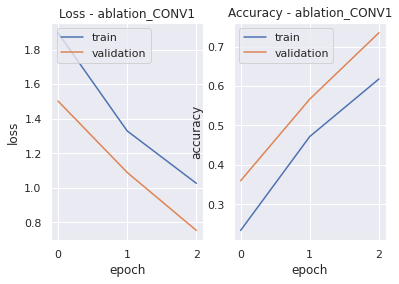

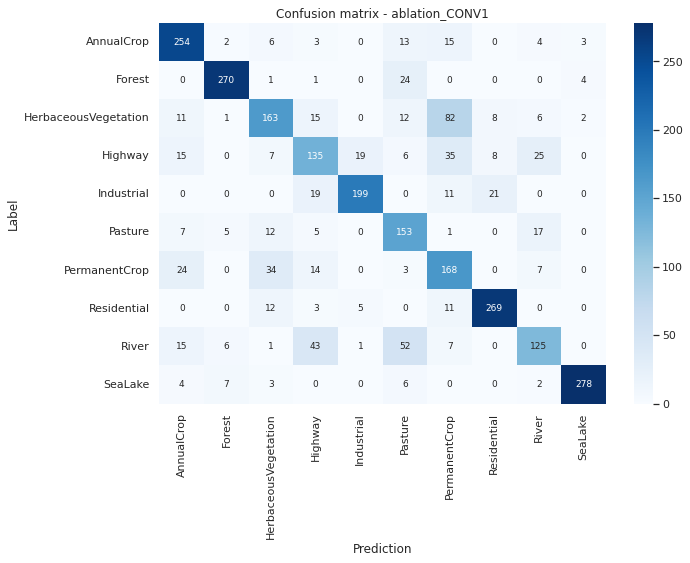

In [30]:
save_plots(history, output_folder, model_name, confusion_matrix_df)

In [31]:
# TURN INTO A FUNCTION

with open("./results.csv", 'a+', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow([model,
                         "removed_layer", 
                         loss,
                         accuracy,
                         wa_prec,
                         wa_rec,
                         wa_f1,
                         wrong_preds,
                         tot_preds,
                         batch_size,
                         len(training_df), # number of images in the training set
                         len(validation_df), # number of images in the validation set
                         len(test_df), # number of images in the test set
                         n_epochs, # cap set for num epochs
                         n_ran_epochs # epoch where it stopped automatically
                        ])
    